In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
from colabcode import ColabCode

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

# Convolutional Neural Networks

## Goals

- Convolutions: Apply on images
- CNNs: Define, Optimize, Inspect, Understand

## Setup

Let's define paths, install & load the necessary Python packages.

**Optional: Save the notebook to your personal google drive to persist changes.**

**Optional: Change runtime to a GPU instance (if using Google Colab)** 

Mount your google drive to store data and results (if running the code in Google Colab).

In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

**Modify the following paths if necessary.**

That is where your data will be stored.

In [4]:
from pathlib import Path

if IN_COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/bveri")
else:
    DATA_PATH = Path("/workspace/code/data")

Install the package `dl_cv_lectures`.

The following code installs the package from a local repository (if available), otherwise it installs it from the exercise repository.

In [5]:
try:
    import dl_cv_lectures

    print("dl_cv_lectures installed, all good")
except ImportError as e:
    import os

    if Path("/workspace/code/src").exists():
        print("Installing from local repo")
        os.system("cd /workspace/code  && pip install .")
    else:
        print("Installing from git repo")
        os.system("pip install git+https://github.com/i4Ds/bveri-exercises-hs2024")

dl_cv_lectures installed, all good


Load all packages

In [6]:
import io
import math
import random
from typing import Callable

import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torchshow as ts
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

Define a default device for your computations.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cpu


## 1) Convolutions in PyTorch

We apply a _convolution_ on images.

Let's get an image.

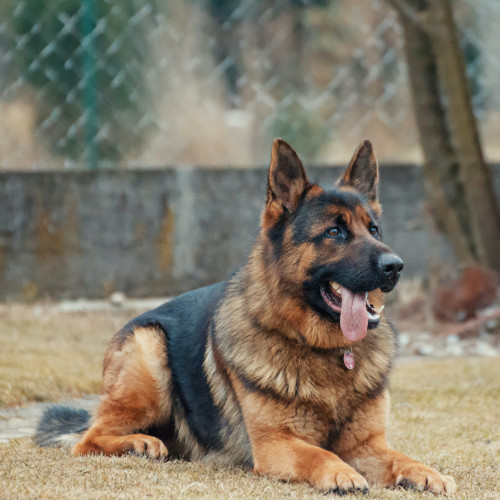

In [8]:
url = "https://github.com/pytorch/vision/blob/main/gallery/assets/dog2.jpg?raw=true"
r = requests.get(url, allow_redirects=True)
image = Image.open(io.BytesIO(r.content))

image

We can now perform *convolutions*. There are two approaches for this:

- *Functional* approach, using functions that are *stateless* [nn.functional](https://pytorch.org/docs/stable/nn.functional.html)
- Using modules (objects), which have a *state* and are used in neural networks [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

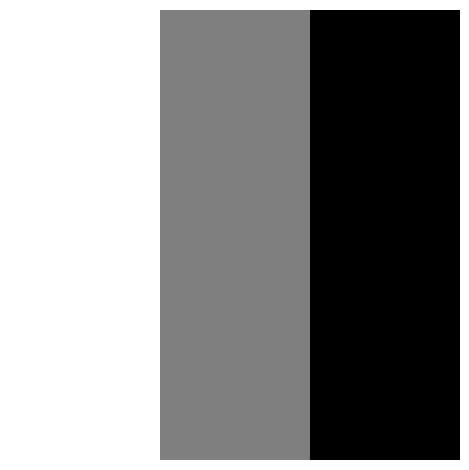

In [9]:
import torch
from torch.nn import functional as F
from torchvision.transforms import functional as TF

# convert PIL.Image to torch.tensor (takes care of channel format -> CHW)
input = TF.pil_to_tensor(image).float() / 255.0

# define filter by hand
filter = filter = (
    torch.tensor(
        [
            [[1, 0, -1], [1, 0, -1], [1, 0, -1]],  # R
            [[1, 0, -1], [1, 0, -1], [1, 0, -1]],  # G
            [[1, 0, -1], [1, 0, -1], [1, 0, -1]],  # B
        ]
    )
    .unsqueeze(0)
    .float()
)

ts.show(filter, show_axis=False)

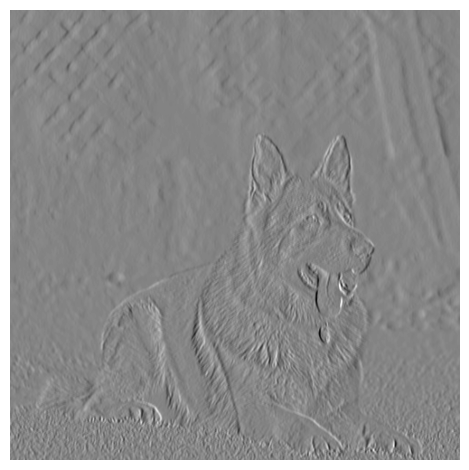

In [10]:
# functional approach
result = F.conv2d(input, filter, stride=1, padding=0, dilation=1, groups=1)

# rescale result to visualize it as an image
result_scaled = (result - result.min()) / (result.max() - result.min())

ts.show(result_scaled)

Now we perform a *convolution* using a *module*. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

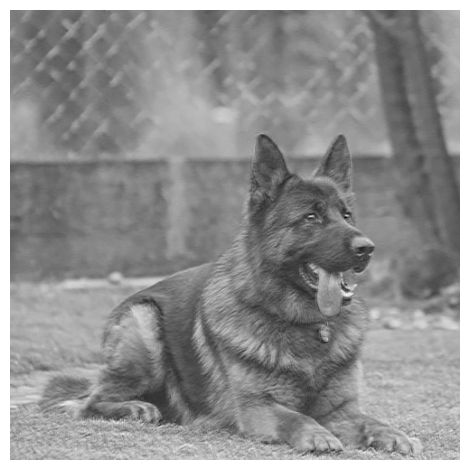

In [11]:
# module
conv = torch.nn.Conv2d(
    in_channels=3,
    out_channels=1,
    kernel_size=3,
    stride=1,
    padding=0,
    dilation=1,
    groups=1,
)

result = conv(input)

# rescale result to visualize it as an image
result_scaled = (result - result.min()) / (result.max() - result.min())


ts.show(result_scaled)

**Question**: What is the difference between the *functional* and *module* approach? What happens in the *module* approach?

The Key difference lies in the weights. In the module approach the weights have to be learned where as in the functional approach you have to give a predefined filter.

Now apply the following operations to the image using the *functional* approach:

- Convolution
- Max Pooling
- Convolution

You can use the filter from above, if possible.

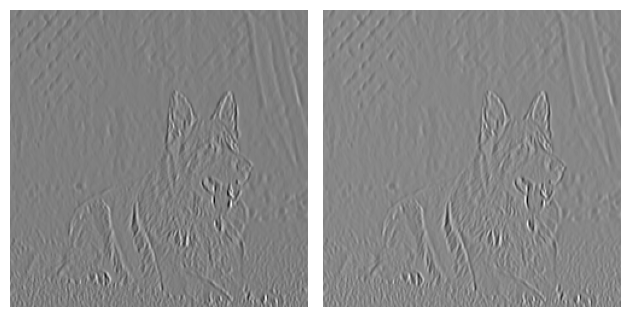

In [12]:
def apply_downsampling(input, filter, sampling_method):
    x = F.conv2d(input, filter, stride=1, padding=0, dilation=1, groups=1)
    x = sampling_method(x, kernel_size=(2, 2), stride=(2, 2))
    result = F.conv2d(
        x, filter[:, 0:1, :, :], stride=1, padding=0, dilation=1, groups=1
    )

    result_scaled = (result - result.min()) / (result.max() - result.min())
    return result_scaled


max_pooling = apply_downsampling(input, filter, F.max_pool2d)
avg_pooling = apply_downsampling(input, filter, F.avg_pool2d)
imgs = torch.stack([max_pooling, avg_pooling], axis=0).to(torch.float32)

# rescale result to visualize it as an image
max_pool_scaled = (max_pooling - max_pooling.min()) / (
    max_pooling.max() - max_pooling.min()
)


ts.show(imgs)

## 2) CNN Properties

In the following we will conduct a few experiments to understand how CNNs work and to contrast them with MLPs.

### Data

We create a modified MNIST dataset.

In [13]:
from functools import partial

import torch
import torchvision
from torch.nn import functional as F
from torchvision import transforms

from dl_cv_lectures.transform import RandomQuadrantPad

# Create the MNIST dataset with the custom transform
ds_mnist_train = torchvision.datasets.MNIST(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=RandomQuadrantPad(choices=["top_left"]),
)

# Create the MNIST dataset with the custom transform
ds_mnist_test_tl = torchvision.datasets.MNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=RandomQuadrantPad(choices=["top_left"]),
)

# Create the MNIST dataset with the custom transform
ds_mnist_test_br = torchvision.datasets.MNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=RandomQuadrantPad(choices=["bottom_right"]),
)

Let's visualize a few data points.

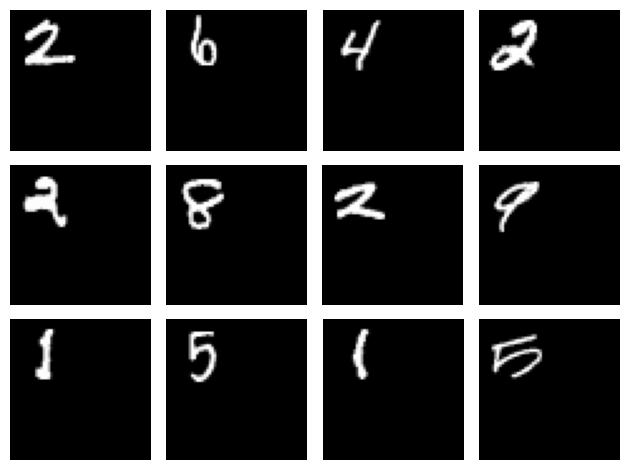

In [14]:
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, batch_size=12, shuffle=True, num_workers=4
)

# Let's check the first batch
images, labels = next(iter(dl_mnist_train))
import torchshow

ts.show(images)

**Question**: What do you notice?

### Architecture Definition

We define a CNN with the following architecture:

- Input Shape: (1, 28 *  2, 28 *2)
- Convolution: 8 Filters, Kernel-Size 5x5
- Max Pooling: Stride 2, Kernel-Size 2
- Convolution: 16 Filter, Kernel-Size 5x5
- Max Pooling: Stride 2, Kernel-Size 2
- FC: 32 neurons
- FC: 16 neurons
- FC: 10 neurons (because we have 10 classes)

We use ReLU after each layer and subclass `torch.nn.Module`.

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torchinfo


class Net(nn.Module):
    def __init__(self, num_channel=8):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, num_channel, (5, 5), padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(num_channel, num_channel * 2, 5, padding=2)
        self.conv3 = nn.Conv2d(num_channel * 2, num_channel * 4, 5, padding=2)
        self.conv4 = nn.Conv2d(num_channel * 4, 10, 3, padding=1)

    def forward(self, x):
        # Layer with Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = torch.mean(x, dim=(2, 3))
        return x


net = Net()

print(net)
print(torchinfo.summary(net, input_size=(1, 1, 56, 56)))

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 56, 56]            208
├─MaxPool2d: 1-2                         [1, 8, 28, 28]            --
├─Conv2d: 1-3                            [1, 16, 28, 28]           3,216
├─MaxPool2d: 1-4                         [1, 16, 14, 14]           --
├─Conv2d: 1-5                            [1, 32, 14, 14]           12,832
├─MaxPool2d: 1-6                         [1, 32, 7, 7]

**Question**: Explain why this layer is defined how it is `nn.Linear(num_channel*2 * 11 * 11, num_channel*4)`.

**Question**: Examine the number of parameters per layer. What do you notice?

### Training

We define loss function and optimizer. Since we are modelling a classification problem we use the _cross-entropy loss_. The Adam-Optimizer is a good default.

In [16]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Let's define the training-loop.

In [17]:
def train_one_epoch(
    data_loader: torch.utils.data.DataLoader,
    net: torch.nn.Module,
    optimizer: torch.optim.Adam,
    loss_fn: Callable,
    device: str = "cpu",
    verbose: bool = True,
):

    net = net.to(device)

    with tqdm(data_loader, unit="batch", disable=not verbose) as tepoch:

        total_samples_seen = 0
        total_correct = 0

        for step, (X, y) in enumerate(tepoch):

            # Update Step
            logits = net(X.to(device))
            loss = loss_fn(logits, y.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate Accuracy
            class_probabilities = torch.softmax(logits, axis=-1).detach().cpu()
            y_hat = (
                class_probabilities.argmax(dim=1, keepdim=True).squeeze().detach().cpu()
            )

            num_correct = (y_hat == y).sum().item()
            num_samples = X.shape[0]
            batch_accuracy = num_correct / num_samples

            # Epoch Statistics
            total_samples_seen += num_samples
            total_correct += num_correct
            epoch_accuracy = total_correct / total_samples_seen

            if verbose:
                tepoch.set_postfix(
                    loss=loss.item(),
                    accuracy_batch=batch_accuracy,
                    accuracy_epoch=epoch_accuracy,
                )

Now we train our model.

In [ ]:
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, batch_size=256, shuffle=True, num_workers=4
)

total_epochs = 5
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_mnist_train, net, optimizer, loss_fn, device=device)

Starting Epoch: 1 / 5


  0%|          | 0/235 [00:00<?, ?batch/s]

Starting Epoch: 2 / 5


  0%|          | 0/235 [00:00<?, ?batch/s]

Starting Epoch: 3 / 5


  0%|          | 0/235 [00:00<?, ?batch/s]

Starting Epoch: 4 / 5


  0%|          | 0/235 [00:00<?, ?batch/s]

Starting Epoch: 5 / 5


  0%|          | 0/235 [00:00<?, ?batch/s]

We evaluate our model on test data. Lets define the test dataset and look at a few samples.


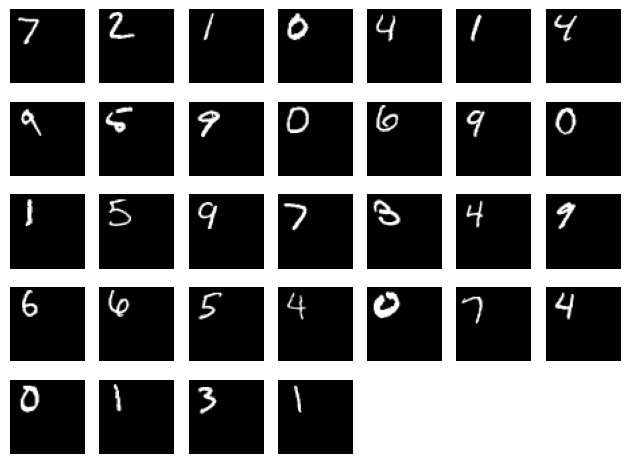

In [ ]:
dl_mnist_test_tl = torch.utils.data.DataLoader(
    ds_mnist_test_tl, batch_size=32, shuffle=False
)

images, labels = next(iter(dl_mnist_test_tl))

ts.show(images)

**Question**: Do you think the model will perform well?

In [ ]:
def eval_loop(
    data_loader: torch.utils.data.DataLoader,
    net: torch.nn.Module,
    loss_fn: Callable,
    device: str = "cpu",
) -> tuple[float, torch.Tensor, torch.Tensor]:

    net = net.to(device)
    net.eval()
    with tqdm(data_loader, unit="batch") as tepoch:

        total_samples_seen = 0
        total_correct = 0

        y_list = list()
        y_hat_list = list()

        for step, (X, y) in enumerate(tepoch):

            # Forward Pass
            with torch.no_grad():
                logits = net(X.to(device))
            loss = loss_fn(logits, y.to(device))

            # Predictions
            class_probabilities = torch.softmax(logits, axis=-1).detach().cpu()
            y_hat = (
                class_probabilities.argmax(dim=1, keepdim=True).squeeze().detach().cpu()
            )

            # Metrics
            num_correct = (y_hat == y).sum().item()
            num_samples = X.shape[0]
            total_samples_seen += num_samples
            total_correct += num_correct
            epoch_accuracy = total_correct / total_samples_seen

            tepoch.set_postfix(
                loss=loss.item(),
                accuracy_epoch=epoch_accuracy,
            )

            # save preds and targets
            y_list.append(y.cpu())
            y_hat_list.append(y_hat.cpu())

    return epoch_accuracy, torch.concat(y_list), torch.concat(y_hat_list)

In [ ]:
test_accuracy, y, y_hat = eval_loop(dl_mnist_test_tl, net, loss_fn, device=device)

print(f"Test Accuracy:  {test_accuracy:.3f}")

  0%|          | 0/313 [00:00<?, ?batch/s]

C:\Users\viety\AppData\Local\Temp\ipykernel_9156\305671605.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.conv3(x))


Test Accuracy:  0.554


Now, we use the following test data.

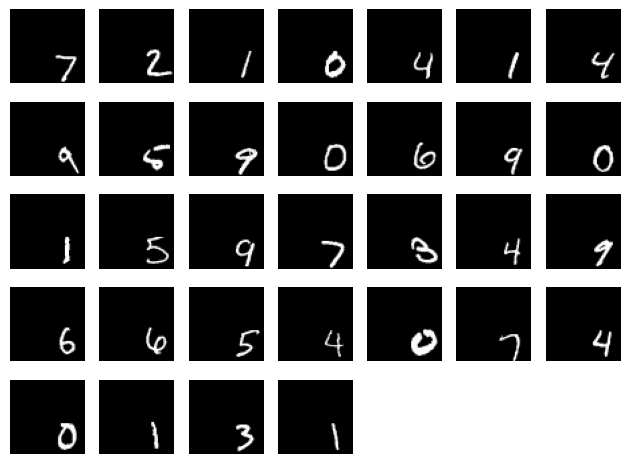

In [ ]:
dl_mnist_test_br = torch.utils.data.DataLoader(
    ds_mnist_test_br, batch_size=32, shuffle=False
)

images, labels = next(iter(dl_mnist_test_br))

ts.show(images)

**Question**: How good is the model in this case?

Validate your hypothesis.

In [ ]:
test_accuracy, y, y_hat = eval_loop(dl_mnist_test_br, net, loss_fn, device=device)

print(f"Test Accuracy:  {test_accuracy:.3f}")

  0%|          | 0/313 [00:00<?, ?batch/s]

C:\Users\viety\AppData\Local\Temp\ipykernel_9156\305671605.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.conv3(x))


Test Accuracy:  0.115


**Question**: What happened?

**Task**: Try to improve the model by making architectural changes.